**Transfer Learning**

This dataset contains animals from different classes. To make it work, perform the following steps:

1. create a directory in the project root called "data"
2. create two folders inside, named "train" and "val"
3. inside these folders, put one folder for each class that you want to use
4. In this example, we use "cat", "lion", "panda", and "wolf"


Link to the dataset: https://www.kaggle.com/datasets/iamsouravbanerjee/animal-image-dataset-90-different-animals?resource=download

Reference: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import time
import os
from tempfile import TemporaryDirectory

In [2]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data'
model_params = 'model_params'

if not os.path.isdir(model_params):
  os.mkdir(model_params)
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Functions
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data).item()
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))

        source = os.path.join(tempdir, 'best_model_params.pt')
        destination = os.path.join(model_params, 'best_model_params.pt')
        os.system('cp ' + source + ' ' + destination)
    return model



Note that we have to map the ImageNet label order to the new dataset label order. For this, we "approximate" by taking all the labels in imagenet that contain the labels (even if they contain also some additional labels, but we just need an estimate of the accuracy), and create a mapping through a python dictionary.

In [4]:
import requests
import json
import io

# Get the list of labels for imagenet
imagenet_labels_path = "https://raw.githubusercontent.com/" \
                       "anishathalye/imagenet-simple-labels/" \
                       "master/imagenet-simple-labels.json"
r2 = requests.get(imagenet_labels_path)
imagenet_labels = json.load(io.StringIO(r2.text))

class_map = {}
for i, c in enumerate(class_names):
    # match by checking if the class name contains the substring
    all_labels = [(j, l) for j, l in enumerate(imagenet_labels) if c in l]
    # note that there is some "noise", e.g., lionfish contains lion
    #   but for now let's ignore that :D
    print(c, all_labels)
    for j, l in all_labels:
        class_map[j] = i
print(class_map)


cat [(143, 'oystercatcher'), (281, 'tabby cat'), (282, 'tiger cat'), (283, 'Persian cat'), (284, 'Siamese cat'), (358, 'European polecat'), (484, 'catamaran')]
lion [(150, 'sea lion'), (291, 'lion'), (396, 'lionfish')]
panda [(387, 'red panda'), (388, 'giant panda')]
wolf [(77, 'wolf spider'), (269, 'grey wolf'), (270, 'Alaskan tundra wolf'), (271, 'red wolf')]
{143: 0, 281: 0, 282: 0, 283: 0, 284: 0, 358: 0, 484: 0, 150: 1, 291: 1, 396: 1, 387: 2, 388: 2, 77: 3, 269: 3, 270: 3, 271: 3}


In [5]:
def compute_acc(model, loader, device, labels_map=None):
    total, correct = 0, 0
    model.eval()
    model.to(device)
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        preds = model(images).argmax(dim=1)
        if labels_map is not None:                
            preds = torch.tensor([labels_map.get(int(p.item()), -1) for p in preds], device=device)
        correct += (labels == preds.type(labels.dtype)).sum().item()
        total += images.shape[0]
    return correct / total

model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')

# test acc before finetuning
acc_before = compute_acc(model_conv, dataloaders['val'], device, class_map)
print(f"accuracy before finetuning: {acc_before}")


accuracy before finetuning: 0.75


In [6]:

# freeze all layers
for param in model_conv.parameters():
    param.requires_grad = False

# parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, len(class_names))

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# only parameters of final layer are being optimized
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=2)


Epoch 0/1
----------
train Loss: 1.1749 Acc: 0.4896
val Loss: 0.3246 Acc: 0.8750

Epoch 1/1
----------
train Loss: 0.7040 Acc: 0.7344
val Loss: 0.1516 Acc: 0.9792

Training complete in 1m 40s
Best val Acc: 0.979167


In [7]:

acc_after = compute_acc(model_conv, dataloaders['val'], device)
print(f"accuracy after finetuning: {acc_after}")

accuracy after finetuning: 0.9791666666666666


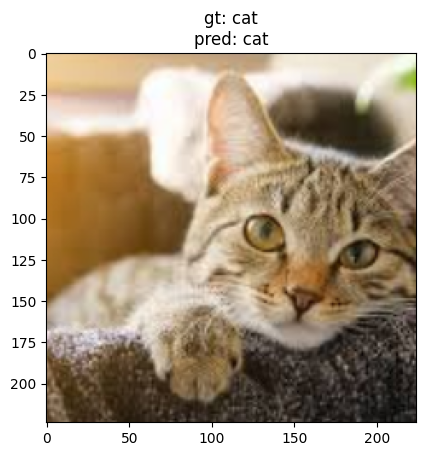

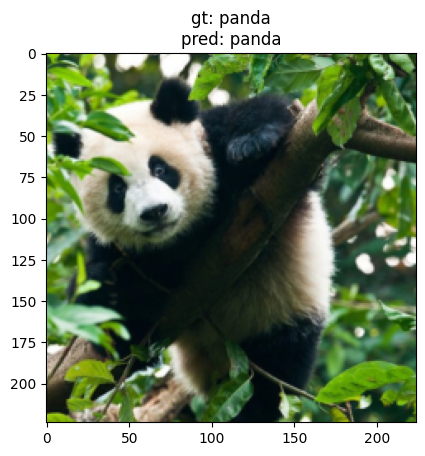

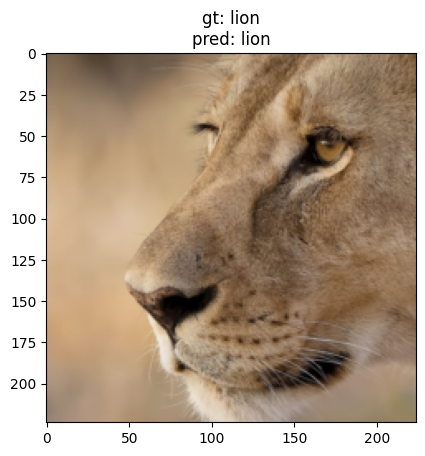

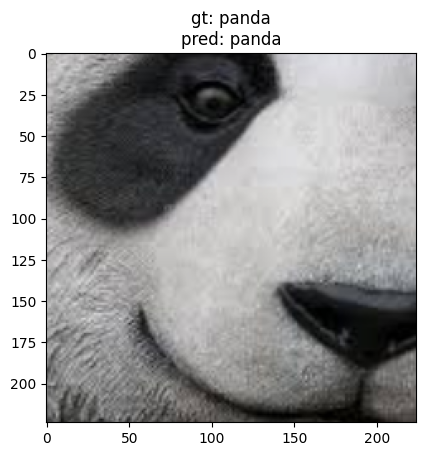

In [8]:
def imshow(t, title=None):
    """Display image for Tensor."""
    t = t.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    t = std * t + mean
    t = np.clip(t, 0, 1)
    plt.imshow(t)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

images, labels = next(iter(dataloaders['val']))
preds = model_conv(images).argmax(dim=1)
preds = [class_names[p] for p in preds]
ground_truth = [class_names[p] for p in labels]
titles = [f"gt: {t}\npred: {p}" for t, p in zip(preds, ground_truth)]
for image, title in zip(images, titles):
    imshow(image, title)